This model uses a different approach where it asks users about the symptoms they are facing and report the probable disease accordingly

In [1]:
pip install pyttsx3

Let us begin by importing all necessary libraries.

In [3]:
pip install shap

In [4]:
import re
import pandas as pd
import numpy as np
import pyttsx3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.tree import _tree
import shap
import csv
import warnings

Let's now load the datasets available on Kaggle. I have downloaded the dataset and uploaded on the session storage in Google Colab.

In [5]:
# Load Data
training = pd.read_csv('Training.csv')
testing = pd.read_csv('Testing.csv')
cols = training.columns[:-1]
print('----TRAIN----',training.head(),sep='\n')
print('----TEST----',testing.head(),sep='\n')
x = training[cols]
y = training['prognosis']

----TRAIN----
   itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
0        1          1                     1                    0          0   
1        0          1                     1                    0          0   
2        1          0                     1                    0          0   
3        1          1                     0                    0          0   
4        1          1                     1                    0          0   

   chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  ...  \
0       0           0             0        0                 0  ...   
1       0           0             0        0                 0  ...   
2       0           0             0        0                 0  ...   
3       0           0             0        0                 0  ...   
4       0           0             0        0                 0  ...   

   blackheads  scurring  skin_peeling  silver_like_dusting  \
0           0         

In [6]:
#see the columns
testing.columns

Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'blackheads', 'scurring', 'skin_peeling', 'silver_like_dusting',
       'small_dents_in_nails', 'inflammatory_nails', 'blister',
       'red_sore_around_nose', 'yellow_crust_ooze', 'prognosis'],
      dtype='object', length=133)

In [7]:
# Encode target labels
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
y.shape

(4920,)

In [8]:
# Data Preprocessing: Handle missing values (if any) and scale features
x = x.fillna(x.mean())  # Fill missing values with mean
scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

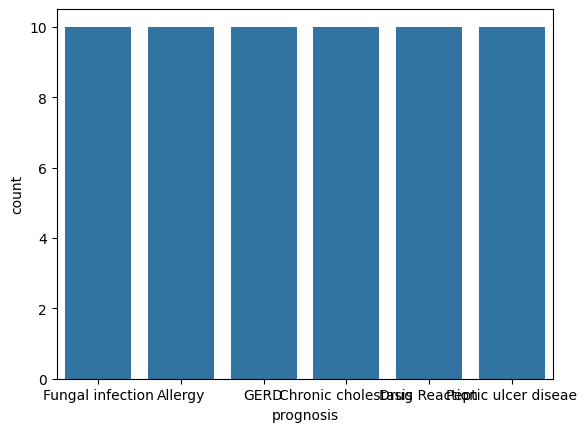

In [9]:
# Explore data distribution and relationships with target variable (credit score)
# Use techniques like histograms, boxplots, scatter plots
import matplotlib.pyplot as plt

sns.countplot(data=training[:60],x="prognosis")
plt.show()

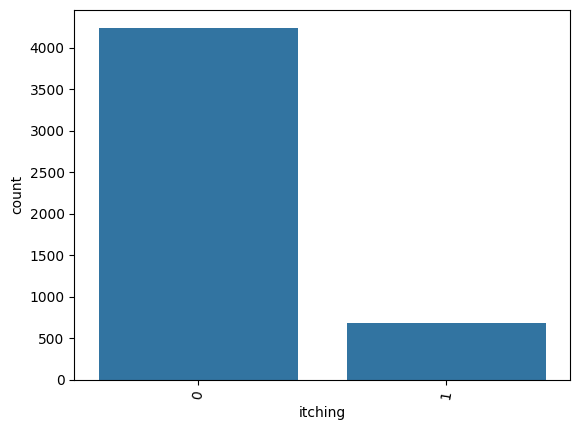

In [10]:
sns.countplot(x=training["itching"])
plt.xticks(rotation=80)
plt.show()

In [11]:
training["itching"].value_counts()

,count
itching,
0,4242
1,678


In [12]:
# Split Data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
testx = testing[cols]
testy = le.transform(testing['prognosis'])

In [13]:
# # Feature Selection using f_classif
## can be incorporated to choose only limited features
# selector = SelectKBest(f_classif, k=10)
# x_train = selector.fit_transform(x_train, y_train)
# x_test = selector.transform(x_test)
# selected_features = cols[selector.get_support()]

In [14]:
# Model Development
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

# Cross-Validation and Model Performance
performance_metrics = {}
for name, model in models.items():
    model.fit(x_train, y_train)
    scores = cross_val_score(model, x_test, y_test, cv=5)
    y_pred = model.predict(x_test)

    performance_metrics[name] = {
        'Cross-Validation Accuracy': scores.mean(),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'Classification Report': classification_report(y_test, y_pred, target_names=le.classes_)
    }

    print(f"{name} - Cross-validation accuracy: {scores.mean():.2f}")
    print(f"{name} - Precision: {precision_score(y_test, y_pred, average='weighted'):.2f}")
    print(f"{name} - Recall: {recall_score(y_test, y_pred, average='weighted'):.2f}")
    print(f"{name} - F1 Score: {f1_score(y_test, y_pred, average='weighted'):.2f}")
    print(f"{name} - Classification Report:\n{performance_metrics[name]['Classification Report']}\n")


Decision Tree - Cross-validation accuracy: 0.99
Decision Tree - Precision: 1.00
Decision Tree - Recall: 1.00
Decision Tree - F1 Score: 1.00
Decision Tree - Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        37
                                   AIDS       1.00      1.00      1.00        42
                                   Acne       1.00      1.00      1.00        42
                    Alcoholic hepatitis       1.00      1.00      1.00        40
                                Allergy       1.00      1.00      1.00        36
                              Arthritis       1.00      1.00      1.00        42
                       Bronchial Asthma       1.00      1.00      1.00        48
                   Cervical spondylosis       1.00      1.00      1.00        37
                            Chicken pox       1.00      1.00      1.00        38
          

In [15]:
# Hyperparameter Tuning (Example for Random Forest)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(x_train, y_train)
print(f"Best parameters for Random Forest: {grid_search.best_params_}")

Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


In [16]:
# Model Interpretability (Optional)
importances = models['Random Forest'].feature_importances_
indices = np.argsort(importances)[::-1]
features = cols[indices]
print("Feature Importances: ", list(zip(features, importances[indices])))

Feature Importances:  [('muscle_pain', 0.01752000164529136), ('itching', 0.01729143081740654), ('mild_fever', 0.01568639349729043), ('fatigue', 0.015423871782358038), ('weight_loss', 0.014583740123669866), ('joint_pain', 0.014348856335344808), ('nodal_skin_eruptions', 0.014113040801247605), ('neck_pain', 0.013781976708716235), ('family_history', 0.013689504808127142), ('vomiting', 0.013596438254492041), ('dark_urine', 0.013332275766243802), ('nausea', 0.012941514059494539), ('yellowing_of_eyes', 0.012836701685214598), ('loss_of_balance', 0.012481448875901094), ('lack_of_concentration', 0.012166172017974389), ('loss_of_appetite', 0.011952969248627116), ('sweating', 0.011686793377262316), ('stomach_pain', 0.011681960137117897), ('altered_sensorium', 0.011646969495548262), ('breathlessness', 0.011618948659559234), ('abdominal_pain', 0.011429586968070815), ('high_fever', 0.011324004552178942), ('chest_pain', 0.011085922683629668), ('chills', 0.01101858579101534), ('passage_of_gases', 0.010

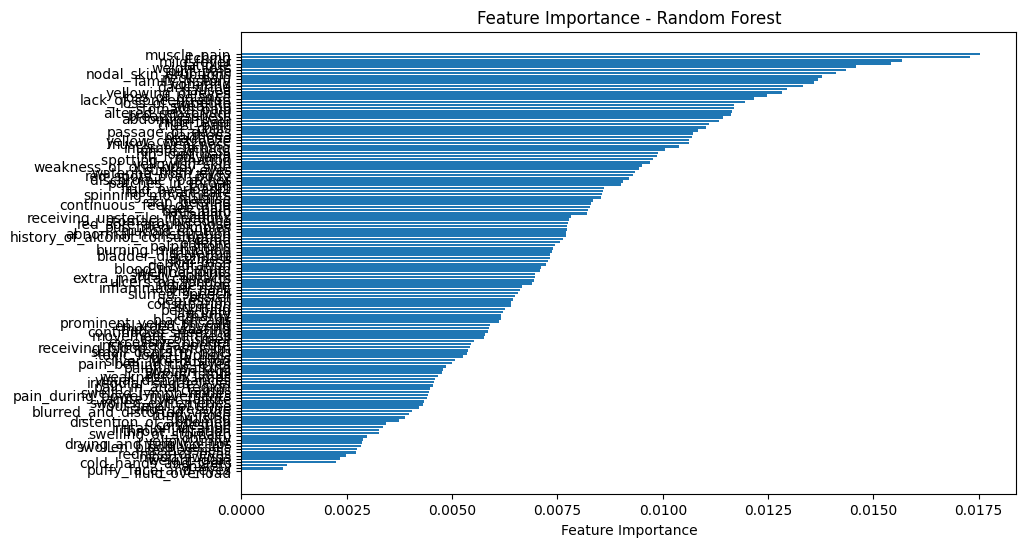

In [17]:
# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Random Forest")
plt.barh(range(len(features)), importances[indices], align="center")
plt.yticks(range(len(features)), features)
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.show()

In [19]:
# print(f"Number of selected features: {len(selected_features)}")
print(f"Shape of x_test: {x_test.shape}")
# print(selected_features)
# print(x_test.shape)
# print(selected_features_indices.shape)


Shape of x_test: (1624, 132)


In [ ]:
# # Re-check if the test data corresponds to selected features
# x_test_selected = x_test[:, selector.get_support()]
# shap_values = explainer.shap_values(x_test_selected)
# shap.summary_plot(shap_values, x_test_selected, feature_names=selected_features)

# # Initialize the SHAP explainer for Random Forest
# explainer = shap.TreeExplainer(models['Random Forest'])

# # Compute SHAP values
# shap_values = explainer.shap_values(x_test)

# # Check if SHAP values is a list (multiclass case)
# if isinstance(shap_values, list):
#     # Select the class index you are interested in
#     class_idx = 0  # Adjust this index based on your class of interest
#     shap.summary_plot(shap_values[class_idx], x_test, feature_names=selected_features)
# else:
#     # Binary classification case
#     shap.summary_plot(shap_values, x_test, feature_names=selected_features)


# # ... (rest of your code)

# # Re-check if the test data corresponds to selected features
# selected_features_indices = np.where(selector.get_support())[0]
# x_test_selected = x_test[:, selected_features_indices]
# explainer = shap.Explainer(models['Random Forest'])
# shap_values = explainer.shap_values(x_test_selected)
# shap.summary_plot(shap_values, x_test_selected, feature_names=selected_features)

Below is the chatbot code

In [20]:
# Load Dictionaries and Initialize the Chatbot
severityDictionary = dict()
description_list = dict()
precautionDictionary = dict()

def readn(nstr):
    engine = pyttsx3.init()
    engine.setProperty('voice', "english+f5")
    engine.setProperty('rate', 130)
    engine.say(nstr)
    engine.runAndWait()
    engine.stop()

In [26]:
# Existing code for loading dictionaries, chatbot interaction, and predicting diseases...


def getSeverityDict():
    global severityDictionary
    with open('Symptom_severity.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')

        for row in csv_reader:
            try:
                severityDictionary[row[0]] = int(row[1])
            except IndexError:
                print(f"Warning: Row with missing value in Symptom_severity.csv: {row}")


def getDescription():
    global description_list
    with open('symptom_Description.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            description_list[row[0]] = row[1]

def getprecautionDict():
    global precautionDictionary
    with open('symptom_precaution.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            precautionDictionary[row[0]] = [row[1], row[2], row[3], row[4]]

def getInfo():
    print("-----------------------------------HealthCare ChatBot-----------------------------------")
    print("\nYour Name? \t\t\t\t", end="->")
    name = input("")
    print("Hello, ", name)

def check_pattern(dis_list, inp):
    pred_list = []
    inp = inp.replace(' ', '_')
    patt = f"{inp}"
    regexp = re.compile(patt)
    pred_list = [item for item in dis_list if regexp.search(item)]
    return bool(pred_list), pred_list

def sec_predict(symptoms_exp):
    df = pd.read_csv('Training.csv')
    X = df.iloc[:, :-1]
    y = df['prognosis']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)

    symptoms_dict = {symptom: index for index, symptom in enumerate(X)}
    input_vector = np.zeros(len(symptoms_dict))
    for item in symptoms_exp:
        input_vector[symptoms_dict[item]] = 1

    return rf_clf.predict([input_vector])

def print_disease(node):
    node = node[0]
    val = node.nonzero()
    disease = le.inverse_transform(val[0])
    return list(map(lambda x: x.strip(), list(disease)))

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    chk_dis = ",".join(feature_names).split(",")
    symptoms_present = []

    while True:
        print("\nEnter the symptom you are experiencing  \t\t", end="->")
        disease_input = input("")
        conf, cnf_dis = check_pattern(chk_dis, disease_input)
        if conf == 1:
            print("searches related to input: ")
            for num, it in enumerate(cnf_dis):
                print(num, ") ", it)
            if num != 0:
                print(f"Select the one you meant (0 - {num}):  ", end="")
                conf_inp = int(input(""))
            else:
                conf_inp = 0

            disease_input = cnf_dis[conf_inp]
            break
        else:
            print("Enter valid symptom.")

    while True:
        print("symptoms recorded: ", symptoms_present)
        print("Search symptom:  ", end="")
        inp = input("")
        conf, cnf_dis = check_pattern(chk_dis, inp)
        if conf == 1:
            print("searches related to input: ")
            for num, it in enumerate(cnf_dis):
                print(num, ") ", it)
            if num != 0:
                print(f"Select the one you meant (0 - {num}):  ", end="")
                conf_inp = int(input(""))
            else:
                conf_inp = 0
            symptoms_present.append(cnf_dis[conf_inp])

        inp = input("Do you want to continue with other symptoms? Yes or No? (y/n): ")
        if inp == "y" or inp == "Y":
            continue
        else:
            break

    second_prediction = sec_predict(symptoms_present)
    print("You may have ", second_prediction)
    print(description_list[second_prediction[0]])

    precautions_list = precautionDictionary[second_prediction[0]]
    print("Take following measures : ")
    for precaution in precautions_list:
        print(precaution)

# Start Interaction
getSeverityDict()
getDescription()
getprecautionDict()
getInfo()
tree_to_code(models['Decision Tree'], cols)

print("----------------------------------------------------------------------------------------")

-----------------------------------HealthCare ChatBot-----------------------------------

Your Name? 				->raj
Hello,  raj

Enter the symptom you are experiencing  		->fever
searches related to input: 
0 )  high_fever
1 )  mild_fever
Select the one you meant (0 - 1):  0
symptoms recorded:  []
Search symptom:  itching
searches related to input: 
0 )  itching
1 )  internal_itching
Select the one you meant (0 - 1):  0
Do you want to continue with other symptoms? Yes or No? (y/n): n
You may have  ['Fungal infection']
In humans, fungal infections occur when an invading fungus takes over an area of the body and is too much for the immune system to handle. Fungi can live in the air, soil, water, and plants. There are also some fungi that live naturally in the human body. Like many microbes, there are helpful fungi and harmful fungi.
Take following measures : 
bath twice
use detol or neem in bathing water
keep infected area dry
use clean cloths
-------------------------------------------------

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
